In [1]:
import os
import glob
import shutil
import numpy as np
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import os

from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers import Convolution2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
import keras.activations

from datetime import datetime

In [2]:
#class_names = ['Painting','Photo','Schematics','Sketch','Text']
data_dir = 'D:\datasets'
data_dir = pathlib.Path(data_dir)
image_h = 180
image_w = 180
batch_s = 32
epochs=10

In [3]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split= 0.2,
  subset = "training",
  seed=42,
  image_size=(image_h, image_w),
  batch_size = batch_s,
)
# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split= 0.2,
  subset = "validation",
  seed=42,
  image_size=(image_h, image_w),
  batch_size = batch_s,
)

Found 41406 files belonging to 5 classes.
Using 33125 files for training.
Found 41406 files belonging to 5 classes.
Using 8281 files for validation.


In [4]:
class_names = train_set.class_names
print(class_names)

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


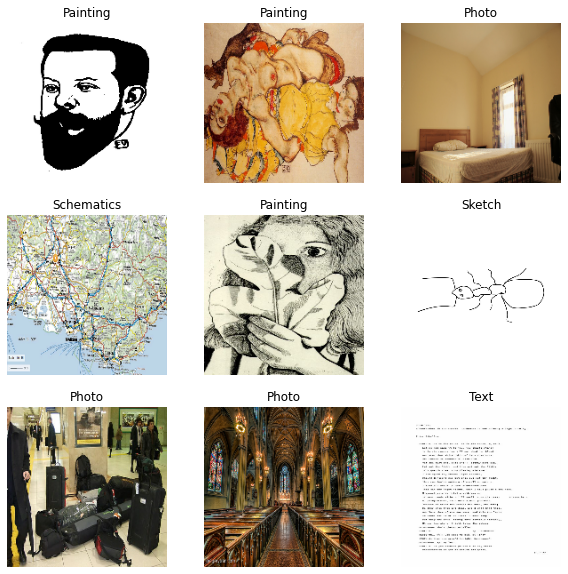

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
    now = datetime.now()
    # initialize CNN
    convolutional_neural_network = Sequential()
    
    #STEP 1 : Resize 
    convolutional_neural_network.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_h, image_w, 3)))
    convolutional_neural_network.add(layers.experimental.preprocessing.RandomFlip("horizontal")),
    convolutional_neural_network.add(layers.experimental.preprocessing.RandomRotation(0.05)),
    convolutional_neural_network.add(layers.experimental.preprocessing.RandomZoom(0.1))
    #STEP 2 : CONVOLUTION 
    
    #kernal size = features detector (matrix)
    #stride = pas de mouvement du features detector
    #input shape => taille des images et nombres de dimensions
    #activation => fonction d'activation

    convolutional_neural_network.add(Convolution2D(filters=16, kernel_size=3, strides=1, padding="same", input_shape=(image_h, image_w, 3), activation="relu"))
    
    #STEP 3 : POOLING 
    
    #pool_size => taille de la matrice de pooling (de base 2)
    #strides => pas du mouvement du pooling matrix (2)
    convolutional_neural_network.add(MaxPooling2D(pool_size=(2,2)))


    #STEP 3.b => SECOND CONVOLUTION and POOLING  
    convolutional_neural_network.add(Convolution2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu"))

    convolutional_neural_network.add(MaxPooling2D(pool_size=(2,2)))
    
    #STEP 3.c => THIRD CONVOLUTION and POOLING 
    convolutional_neural_network.add(Convolution2D(filters=64, kernel_size=3, strides=1, padding="same", activation="relu"))

    convolutional_neural_network.add(MaxPooling2D(pool_size=(2,2)))
    #STEP 4 : FLATTENING

    convolutional_neural_network.add(Flatten())

    #STEP 5 : ANN

    convolutional_neural_network.add(Dense(units=128, activation="softmax"))   
    convolutional_neural_network.add(Dropout(0.4))
    convolutional_neural_network.add(Dense(units=5))

    #COMPILATION 

    convolutional_neural_network.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    convolutional_neural_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                      

In [7]:
#1ere couche Conv2D (16 filtres de taille 3x3x3)
parm_layer1 = 3*3*3*16+16
nom_layer1 = "Conv2D"
print(f"Nombre de paramètres dans {nom_layer1} : {parm_layer1}")
# 2eme couche Conv2D (32 filtres de taille 3x3x3)
parm_layer2 = 16*3*3*32+32
nom_layer2 = "Conv2D"
print(f"Nombre de paramètres dans {nom_layer2} : {parm_layer2}")
# 3eme couche Conv2D (64 filtres de taille 3x3x3)
parm_layer3 = 32*3*3*64+64
nom_layer3 = "Conv2D"
print(f"Nombre de paramètres dans {nom_layer3} : {parm_layer3}")
 
# 1ere couche Dense
parm_layer4 = 22*22*64*128+128
nom_layer4 = "Dense"
print(f"Nombre de paramètres dans {nom_layer4} : {parm_layer4}")
# 2eme couche Dense
parm_layer5 = 128*5+5
nom_layer5 = "Dense"
print(f"Nombre de paramètres dans {nom_layer5} : {parm_layer5}")
 
print(f'Nombre total de paramètres : {parm_layer1+parm_layer2+parm_layer3+parm_layer4+parm_layer5}')

Nombre de paramètres dans Conv2D : 448
Nombre de paramètres dans Conv2D : 4640
Nombre de paramètres dans Conv2D : 18496
Nombre de paramètres dans Dense : 3965056
Nombre de paramètres dans Dense : 645
Nombre total de paramètres : 3989285


In [8]:
    #ENTRAINEMENT
    
    #train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
    #test_data_datagen = ImageDataGenerator(rescale=1./255)
    
    #training_set = train_datagen.flow_from_directory(data_dir,target_size= (image_h,image_w),batch_size=batch_s)
    #test_set = train_datagen.flow_from_directory(data_dir,target_size= (image_h,image_w),batch_size=batch_s)

    history = convolutional_neural_network.fit(train_set,steps_per_epoch=(33125//batch_s),epochs=2,validation_data=test_set,validation_steps=(8281//batch_s))
    history.save('D:\Work\data\Leyenda-main\Leyenda\Livrable1/CNNPainting.h5')

Epoch 1/2
  57/1035 [>.............................] - ETA: 8:00 - loss: 2.0336 - accuracy: 0.2626

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()